# Example notebook for Speckle Flow SIM - Experiment
This notebook demonstrates a experimental reconstruction on a absorptive USAF-1951 resolution target. Full details can be found in our technical paper ["Dynamic Structured Illumination Microscopy with a Neural Space-time Model"](https://arxiv.org/pdf/2206.01397).

### Please cite this work as:
```
@article{cao2022dynamic,
  title={Dynamic Structured Illumination Microscopy with a Neural Space-time Model},
  author={Cao, Ruiming and Liu, Fanglin Linda and Yeh, Li-Hao and Waller, Laura},
  journal={arXiv preprint arXiv:2206.01397},
  year={2022}
}
```

![experiment result](img/experiment_fig.png)

# Import dependencies

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
# %matplotlib inline
import os
import functools
import numpy as np
import jax
import jax.numpy as jnp
from flax import linen as nn
import flax
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import calcil as cc

import speckle_flow
import spacetime
import utils

# Load experimental data

In [32]:
with np.load('experiment.npz') as data:
    im_stack = data['im_stack']
    timepoints = data['timepoints']
    U_speckle = data['U_speckle']
    data_name = 'experiment'
    num_frames = len(timepoints)

### System parameters
System parameters for the experimental data

In [19]:
pixel_size = 2.4
mag = 12.5
dx = pixel_size / mag
RI_medium = 1.0

dim_yx = (400, 540)
padding_yx = (50, 50)
NA = 0.25
wavelength = 0.532
extent = [0, (dim_yx[1] + padding_yx[1] * 2) * dx, 0, (dim_yx[0] + padding_yx[0] * 2) * dx]

param = utils.SystemParameters(dim_yx, wavelength, NA, dx, RI_medium, padding_yx)

### Visualize intensity measurements

interactive(children=(IntSlider(value=0, description='t', max=39), Output()), _dom_classes=('widget-interact',…

<function __main__.updateFrame(t)>

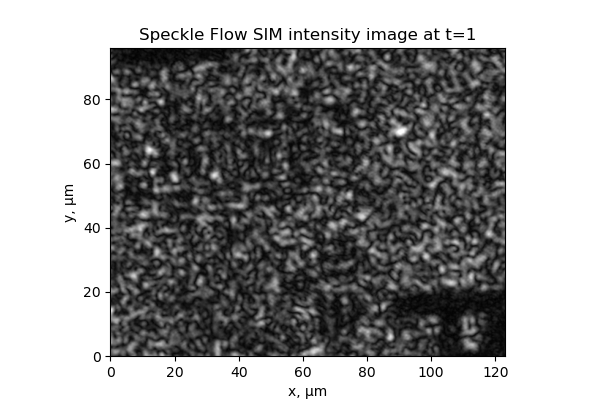

In [20]:
f, ax = plt.subplots(1, 1, figsize=(6, 4), )
frame = []

def init():
    frame.append(ax.imshow(im_stack[0], cmap='gray', extent=extent))
    ax.set_xlabel('x, µm')
    ax.set_ylabel('y, µm')

init()
def updateFrame(t):
    frame[0].set_data(im_stack[t])
    ax.set_title(f'Speckle Flow SIM intensity image at t={t+1}')

interact(updateFrame, t=IntSlider(min=0, max=len(im_stack)-1, step=1, value=0))

# Reconstruction via a neural space-time model

### Neural space-time model definition

In [21]:
mlp_param = spacetime.MLPParameters(net_depth=8, net_width=64, net_activation=nn.celu, skip_layer=4)
motion_mlp_param = spacetime.MLPParameters(net_depth=4, net_width=32, net_activation=nn.relu,
                                           skip_layer=4, kernel_init=nn.initializers.normal(5e-2))
space_time_param = spacetime.SpaceTimeParameters(mlp_out_activation=nn.relu,
                                                 posenc_min=0, posenc_max=8,
                                                 time_posenc_min=0, time_posenc_max=4,
                                                 n_step_coarse_to_fine=2000,
                                                 include_padding=False)

speckle_flow_param = speckle_flow.SpeckleFlowSIMParameters(space_time_param=space_time_param,
                                                          motion_mlp_param=motion_mlp_param, mlp_param=mlp_param)

### Loss definition

In [33]:
def loss_l2(forward_output, variables, input_dict, intermediates):
    loss_l2 = ((input_dict['img'] - forward_output[0]) ** 2).mean()
    return loss_l2

def loss_highfreq(forward_output, variables, input_dict, intermediates, pupil=None):

    loss_highfreq = 0.
    if pupil is not None:
        loss_highfreq = jnp.abs(jnp.fft.fftn(jnp.exp(1.0j * forward_output[1][..., 0] - forward_output[1][..., 1]), axes=(-2, -1)) *
                                (1 - pupil)[jnp.newaxis, :, :]).mean()
    return loss_highfreq

pupil_3na = cc.physics.wave_optics.genPupil((param.dim_yx[0], param.dim_yx[1] ), param.pixel_size, param.na * 3, param.wavelength)
loss_l2_fn = cc.loss.Loss(loss_l2, 'l2')
loss_highfreq_fn = cc.loss.Loss(functools.partial(loss_highfreq, pupil=pupil_3na), 'highfreq')
loss_fn = loss_l2_fn + loss_highfreq_fn * 1e-5  # turn off high freq loss by removing the last term (or setting its weight to 0)

### Initialization of the data loader and the neural space-time model

In [34]:
# load images
batch_size = 4
data_loader = cc.data_utils.loader_from_numpy({'img': im_stack, 't': timepoints}, prefix_dim=(batch_size,), seed=85472, )
sample_input_dict = next(data_loader)[0]

# initialize model
model = speckle_flow.SpeckleFlowSIMCoherent(param, speckle_flow_param)
rng = jax.random.PRNGKey(0)
variables = model.init(rng, input_dict=sample_input_dict)

variables = variables.unfreeze()
variables['params']['speckle_amp'] = jnp.asarray(np.abs(U_speckle))
variables['params']['speckle_phase'] = jnp.asarray(np.angle(U_speckle))
variables = flax.core.FrozenDict(variables)

# output function
def output_fn(variables_, train_state):
    phase_out =  np.array([model.apply(variables_, jnp.array([timepoints[t]]), train_state.step, 
                           method=lambda module, a, s: module.spacetime(a, s)[0,..., 0]) for t in jnp.arange(0, num_frames, num_frames-1)])
    abs_out = np.array([model.apply(variables_, jnp.array([timepoints[t]]), train_state.step,
                        method=lambda module, a, s: module.spacetime(a, s)[0,..., 1]) for t in jnp.arange(0, num_frames, num_frames-1)])
    
    return {'phase': phase_out, 'abs': abs_out}

### Run reconstruction

In [ ]:
%%time
recon_param = cc.reconstruction.ReconIterParameters(save_dir='./checkpoint/{}/'.format(data_name), n_epoch=10000)
no_update_params = cc.reconstruction.ReconVarParameters(lr=0)
spacetime_mlp_params = cc.reconstruction.ReconVarParameters(lr=5e-5, opt='adam', schedule='exponential',
                                                         schedule_kwargs={'transition_steps':40000, 'decay_rate': 0.2})
speckle_amp_params = cc.reconstruction.ReconVarParameters(lr=5e0, opt='sgd', schedule='exponential',
                                                          schedule_kwargs={'transition_steps':40000, 'decay_rate': 0.2},
                                                          delay_update_n_iter=2000, update_every=10)
speckle_phase_params = cc.reconstruction.ReconVarParameters(lr=2e2, opt='sgd', schedule='exponential',
                                                          schedule_kwargs={'transition_steps':40000, 'decay_rate': 0.2},
                                                          delay_update_n_iter=2000, update_every=10)

var_params = {'params': {'spacetime': spacetime_mlp_params, 'speckle_amp': speckle_amp_params, 'speckle_phase': speckle_phase_params,
                         'forward': no_update_params}}
# uncomment the following line to turn off the speckle joint update
# var_params = {'params': {'spacetime': spacetime_mlp_params, 'speckle_amp': no_update_params, 'speckle_phase': no_update_params,
#                          'forward': no_update_params}}

recon_variables, recon = cc.reconstruction.reconstruct_multivars_sgd(model.apply, variables, var_params, data_loader, loss_fn, recon_param, output_fn)

recon_t = np.array([model.apply(recon_variables, jnp.array([timepoints[t]]), 
                       method=lambda module, a: module.spacetime(a)[0,..., ]) for t in jnp.arange(num_frames)])

/home/ruiming/calcil_dev/calcil/reconstruction.py:84: UserWarning: Delayed update for 2000 iterations (the optimization will do nothing).
  warnings.warn('Delayed update for {} iterations (the optimization will do nothing).'.format(var_params.delay_update_n_iter))


epoch: 0, highfreq: 2.5649e-06, l2: 0.0082523, total_loss: 0.0082548, epoch per sec: 33.121
epoch: 100, highfreq: 6.6180e-06, l2: 0.0057746, total_loss: 0.0057812, epoch per sec: 0.89807
epoch: 200, highfreq: 3.3483e-05, l2: 0.0045726, total_loss: 0.0046061, epoch per sec: 0.88489
epoch: 300, highfreq: 3.2337e-05, l2: 0.0042531, total_loss: 0.0042854, epoch per sec: 0.88423
epoch: 400, highfreq: 3.4792e-05, l2: 0.0037629, total_loss: 0.0037977, epoch per sec: 0.89085
epoch: 500, highfreq: 3.3702e-05, l2: 0.0037539, total_loss: 0.0037876, epoch per sec: 0.89278
epoch: 600, highfreq: 3.3688e-05, l2: 0.0036389, total_loss: 0.0036726, epoch per sec: 0.88998
epoch: 700, highfreq: 3.2128e-05, l2: 0.0037408, total_loss: 0.0037730, epoch per sec: 0.89231
epoch: 800, highfreq: 3.2862e-05, l2: 0.0030920, total_loss: 0.0031248, epoch per sec: 0.88817
epoch: 900, highfreq: 3.1295e-05, l2: 0.0035913, total_loss: 0.0036226, epoch per sec: 0.89139
epoch: 1000, highfreq: 3.1540e-05, l2: 0.0030781, tot

### Visualization - through optimization epochs

interactive(children=(IntSlider(value=0, description='i', max=9), Output()), _dom_classes=('widget-interact',)…

<function __main__.updateFrame(i)>

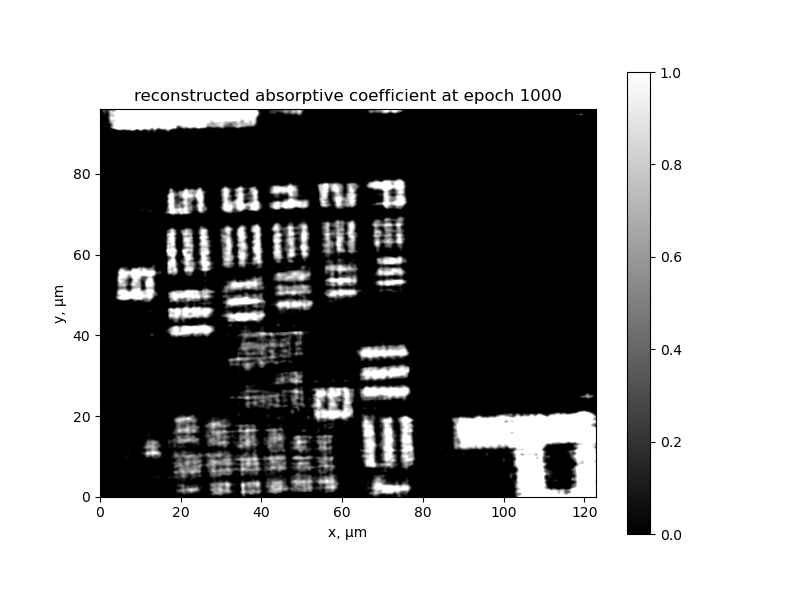

In [61]:
f, ax = plt.subplots(1, 1, figsize=(8, 6), sharex=True, sharey=True)
frame = []

def init():
    frame.append(ax.imshow(np.abs(recon['abs'][0][0]), cmap='gray', clim=(0,1), extent=extent))
    ax.set_xlabel('x, µm')
    ax.set_ylabel('y, µm')
    f.colorbar(frame[0], ax=ax)

init()
def updateFrame(i):
    frame[0].set_data(np.abs(recon['abs'][i][0]))
    ax.set_title(f'reconstructed absorptive coefficient at epoch {(i+1)*1000}')

interact(updateFrame, i=IntSlider(min=0, max=len(recon['abs'])-1, step=1, value=0))

### Visualization - through timepoints

interactive(children=(IntSlider(value=0, description='t', max=39), Output()), _dom_classes=('widget-interact',…

<function __main__.updateFrame_t(t)>

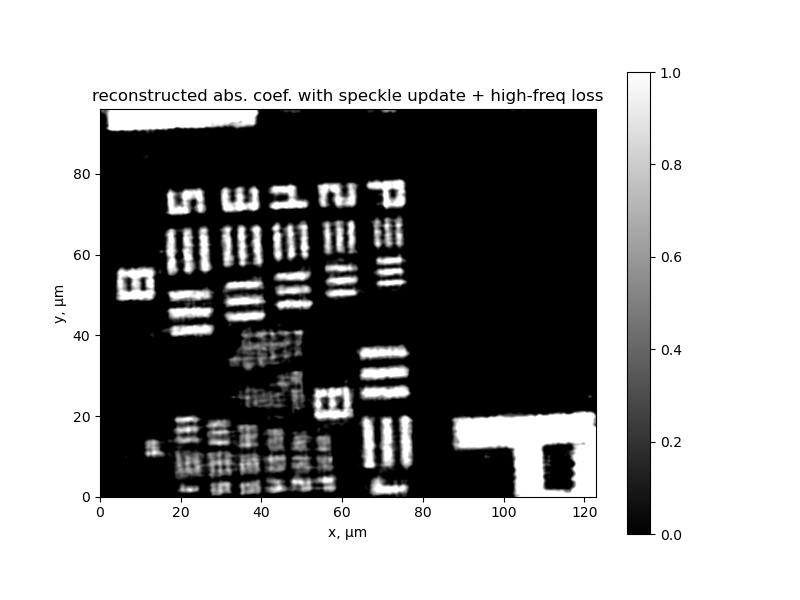

In [62]:
f_t, ax_t = plt.subplots(1, 1, figsize=(8, 6), sharex=True, sharey=True)
frame_t = []

def init_t():
    frame_t.append(ax_t.imshow(np.abs(recon_t[0, :, :, 1]), clim=(0,1.0), cmap='gray', extent=extent))
    ax_t.set_xlabel('x, µm')
    ax_t.set_ylabel('y, µm')
    f.colorbar(frame_t[0], ax=ax_t)

init_t()
def updateFrame_t(t):
    frame_t[0].set_data(np.abs(recon_t[t, :, :, 1]))
    ax_t.set_title('reconstructed abs. coef. with speckle update + high-freq loss')

interact(updateFrame_t, t=IntSlider(min=0, max=recon_t.shape[0]-1, step=1, value=0))